In [1]:
!pip install pyramid.arima
!pip install pyramid

  Using cached https://files.pythonhosted.org/packages/5c/84/57422f2a6ade3161c586545e38b518ba1b7ab30ee4a4acc29110c0aba2bc/pyramid_arima-0.9.0-cp36-cp36m-manylinux1_x86_64.whl


# Predicción de Series Temporales con Redes Neuronales

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from math import sqrt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from google.colab import files
import io
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
from matplotlib import pyplot

Using TensorFlow backend.


# Carga de Dataset

In [573]:
uploaded = files.upload()


Saving Data_sum.csv to Data_sum.csv


In [829]:
dftemp = pd.read_csv(io.BytesIO(uploaded['Data_sum.csv']),sep=',')
dftemp.tail()


,Date,Toneladas
2259,2019-12-24,282.831299
2260,2019-12-26,288.442780
2261,2019-12-27,288.333313
2262,2019-12-30,290.044617
2263,2019-12-31,292.163818


Transformamos la fecha a formato de tiempo y la definimos con Indice del dataframe

In [830]:
dftemp['Date'] = pd.to_datetime(dftemp['Date'], format='%Y-%m-%d')
df = dftemp.set_index('Date')
df.tail()

,Toneladas
Date,
2019-12-24,282.831299
2019-12-26,288.442780
2019-12-27,288.333313
2019-12-30,290.044617
2019-12-31,292.163818


Como paso previo a la aplicacion del modelo se rocede a eliminar Outliers

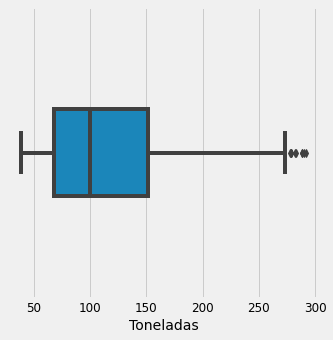

In [831]:
import seaborn as sns
plt.figure(figsize=(5,5))
ax = sns.boxplot(x=df["Toneladas"],width=0.3, whis=1.5)

In [832]:
from scipy import stats 
df=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] 
df2=df


In [834]:
print(df.index.min())
print(df.index.max())

2011-01-03 00:00:00
2019-12-13 00:00:00


In [835]:
print(len(df['2018']))
print(len(df['2019']))

251
241


In [836]:
meses =df.resample('M').mean()
meses

,Toneladas
Date,
2011-01-31,41.847812
2011-02-28,43.431126
2011-03-31,42.974563
2011-04-30,42.099545
2011-05-31,42.268883
...,...
2019-08-31,203.104356
2019-09-30,216.242517
2019-10-31,233.395029


# Visualizaciones

Text(0.5, 0, 'Meses')

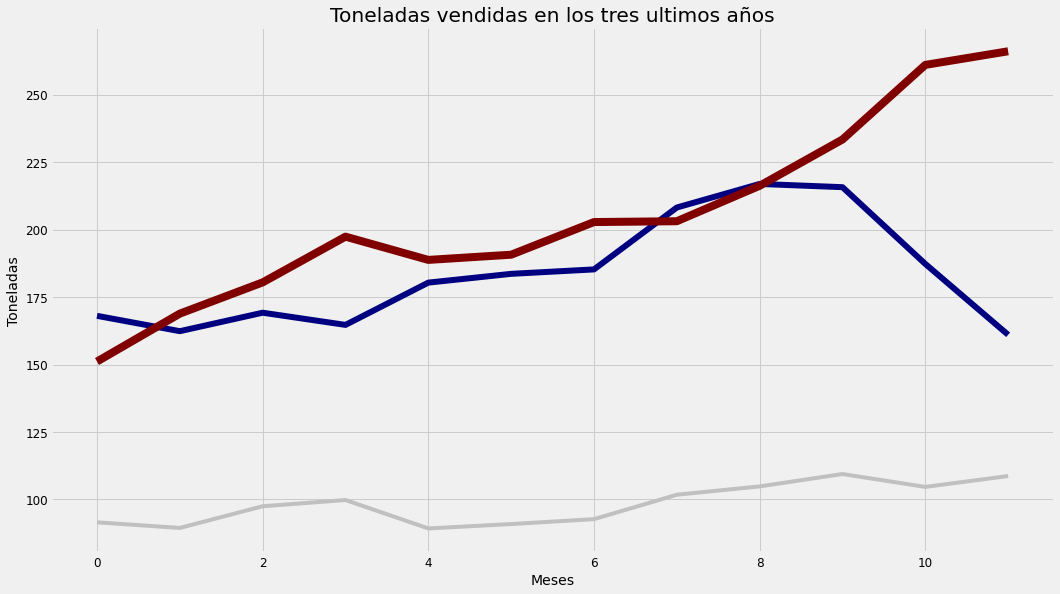

In [746]:
plt.title('Toneladas vendidas en los tres ultimos años')
plt.plot(meses['2016'].values, color="silver",linewidth=4)
plt.plot(meses['2018'].values, color="navy",linewidth=6)
plt.plot(meses['2019'].values, color="maroon",linewidth=8)
plt.ylabel('Toneladas')
plt.xlabel('Meses')


# Pronóstico de Ventas Diarias con Red Neuronal FeddForward

Preprocesado de los datos

In [837]:
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date, time, timedelta
import calendar

In [838]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(datas, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(datas) is list else datas.shape[1]
    dfs = pd.DataFrame(datas)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dfs.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dfs.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)


In [839]:
# split into train and test sets
values = reframed.values
n_train_days = 1575
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1575, 1, 7) (1575,) (671, 1, 7) (671,)


In [869]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='SGD',metrics=["mse"])
    model.summary()
    return model

In [870]:
EPOCHS=40
model = crear_modeloFF()
print (x_train.shape)
print (y_train.shape)
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 1, 7)              56        
_________________________________________________________________
flatten_22 (Flatten)         (None, 7)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
(1575, 1, 7)
(1575,)
Train on 1575 samples, validate on 671 samples
Epoch 1/40
1575/1575 [==============================] - 0s 229us/step - loss: 0.0894 - mse: 0.0130 - val_loss: 0.2303 - val_mse: 0.0603
Epoch 2/40
1575/1575 [==============================] - 0s 181us/step - loss: 0.0544 - mse: 0.0051 - val_loss: 0.3120 - val_mse: 0.1069
Epoch 3/40
1575/1575 [=========================

671


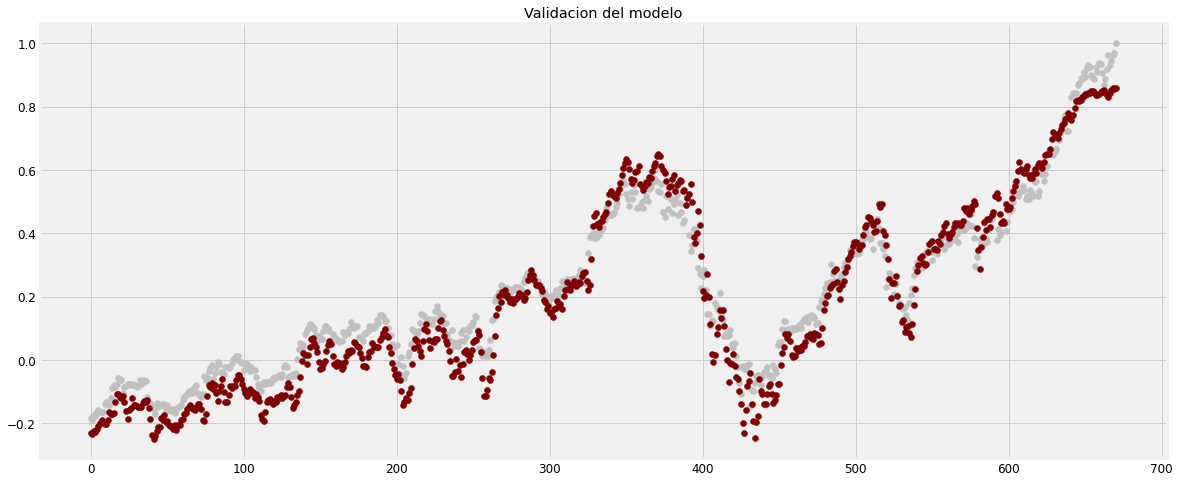

In [871]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='silver')
plt.scatter(range(len(results)),results,c='maroon')
plt.title('Validacion del modelo')
plt.show()

In [872]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,264.510376,264.136292,0.374084
1,264.477325,264.135010,0.342316
2,264.589111,264.201782,0.387329
3,264.578339,264.171173,0.407166
4,264.665344,264.253876,0.411469


In [873]:
compara2.describe()

,real,prediccion,diferencia
count,671.000000,671.000000,671.000000
mean,267.648407,267.423309,0.225120
std,2.040844,2.305410,0.492791
min,264.477325,264.011261,-1.646301
25%,266.037857,265.443787,-0.083633
50%,267.205536,266.778351,0.319977
75%,268.985550,269.310623,0.572693
max,273.757477,272.654877,1.579651


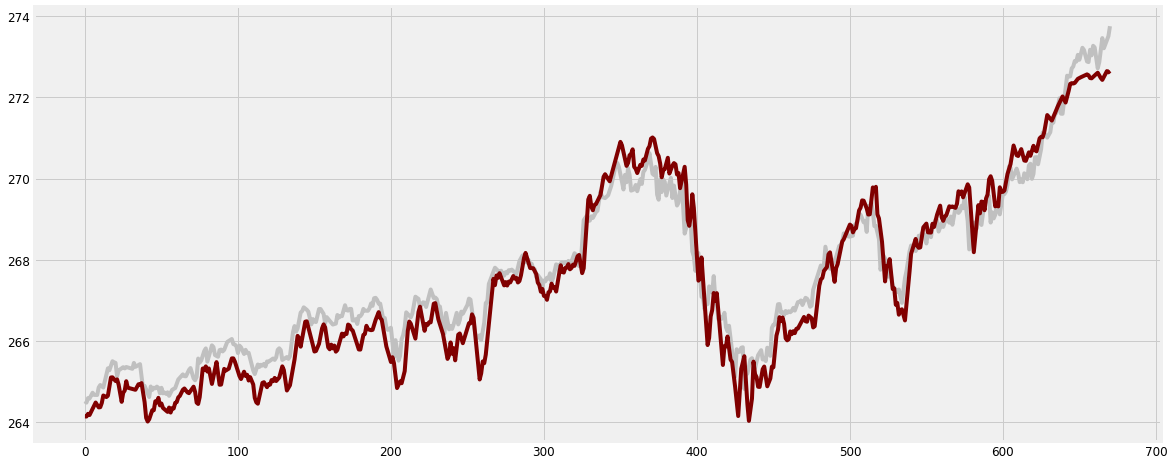

In [874]:
plt.plot(compara2['real'], color='silver')
plt.plot(compara2['prediccion'], color='maroon')

Epoch 1/40
 - 1s - loss: 1016.1754
Epoch 2/40
 - 1s - loss: 2.5587
Epoch 3/40
 - 1s - loss: 2.6153
Epoch 4/40
 - 1s - loss: 2.6121
Epoch 5/40
 - 1s - loss: 2.6757
Epoch 6/40
 - 1s - loss: 2.6437
Epoch 7/40
 - 1s - loss: 2.8238
Epoch 8/40
 - 1s - loss: 2.7878
Epoch 9/40
 - 1s - loss: 2.8233
Epoch 10/40
 - 1s - loss: 2.8212
Epoch 11/40
 - 1s - loss: 2.6808
Epoch 12/40
 - 1s - loss: 2.7708
Epoch 13/40
 - 1s - loss: 2.8515
Epoch 14/40
 - 1s - loss: 2.8033
Epoch 15/40
 - 1s - loss: 2.6958
Epoch 16/40
 - 1s - loss: 2.6546
Epoch 17/40
 - 1s - loss: 2.6689
Epoch 18/40
 - 1s - loss: 2.5909
Epoch 19/40
 - 1s - loss: 2.5950
Epoch 20/40
 - 1s - loss: 2.7006
Epoch 21/40
 - 1s - loss: 2.5103
Epoch 22/40
 - 1s - loss: 2.4996
Epoch 23/40
 - 1s - loss: 2.5490
Epoch 24/40
 - 1s - loss: 2.4461
Epoch 25/40
 - 1s - loss: 2.5329
Epoch 26/40
 - 1s - loss: 2.5299
Epoch 27/40
 - 1s - loss: 2.4034
Epoch 28/40
 - 1s - loss: 2.4091
Epoch 29/40
 - 1s - loss: 2.4916
Epoch 30/40
 - 1s - loss: 2.6654
Epoch 31/40
 - 1

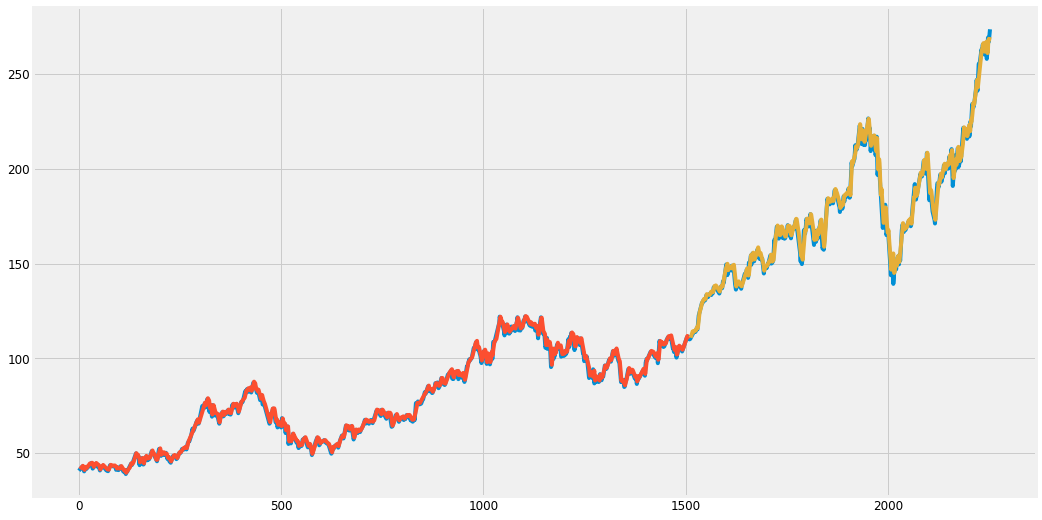

In [764]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
#from google.colab import files
#import io

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# fix random seed for reproducibility
numpy.random.seed(7)

# cargar data
dataframe = df 
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=40, batch_size=2, verbose=2)
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Pronóstico de ventas futuras

In [875]:
ultimosDias = df['2019-11-20':'2019-12-15']
ultimosDias

,Toneladas
Date,
2019-11-20,261.858032
2019-11-21,260.683990
2019-11-22,260.455139
2019-11-25,265.021912
2019-11-26,262.952423
2019-11-27,266.484467
2019-11-29,265.897461
2019-12-02,262.823090
2019-12-03,258.136963


In [847]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1,1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
reframed.head(2)

,var1(t-7),var1(t-6),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.523567,-0.673885,-0.118473,-0.383442,0.068787,-0.006371,-0.400002
8,-0.673885,-0.703186,-0.383442,0.068787,-0.006371,-0.400002,-1.000000


In [876]:
values = reframed.values
x_test = values[2:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
#print(x_test.shape)
#x_test

In [849]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [877]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    #print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

In [878]:
adimen = [x for x in results]    
#print(adimen)
inverted = scaler.inverse_transform(adimen)
#inverted

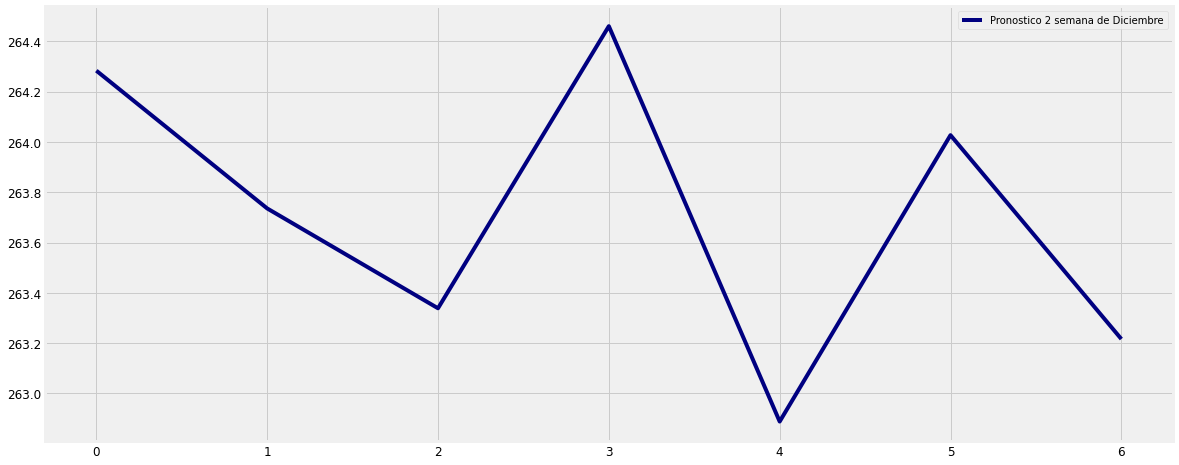

In [879]:
prediccion2SemanaDiciembre = pd.DataFrame(inverted)
prediccion2SemanaDiciembre.columns = ['Pronostico 2 semana de Diciembre']
prediccion2SemanaDiciembre.plot(color='navy')
prediccion2SemanaDiciembre.to_csv('pronostico.csv')

In [880]:
prediccion2SemanaDiciembre

,Pronostico 2 semana de Diciembre
0,264.283398
1,263.735708
2,263.338802
3,264.460190
4,262.888493
5,264.026992
6,263.216469


SARIMA

In [765]:
#!pip install pyramid.arima
#!pip install pyramid

In [766]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from google.colab import files
import io


from pandas import Series
from matplotlib import pyplot

Carga de datos

In [856]:
df2=df2.reset_index()
df2.columns=("year","Toneladas")


In [857]:
df2.shape

(2253, 2)

In [858]:
df2['year'] = pd.to_datetime(df2['year'], format='%Y-%m-%d')
y = df2.set_index('year')
y.index

DatetimeIndex(['2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13', '2011-01-14',
               ...
               '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13'], dtype='datetime64[ns]', name='year', length=2253, freq=None)

In [859]:
y.isnull().sum()

Toneladas    0
dtype: int64

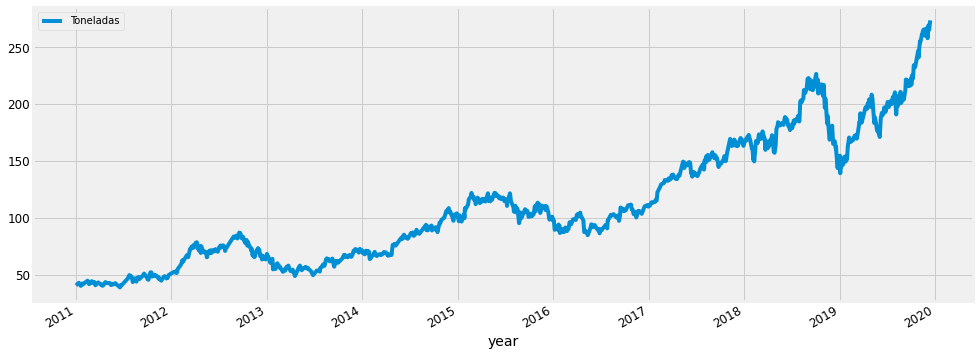

In [860]:
y.plot(figsize=(15, 6))
plt.show()

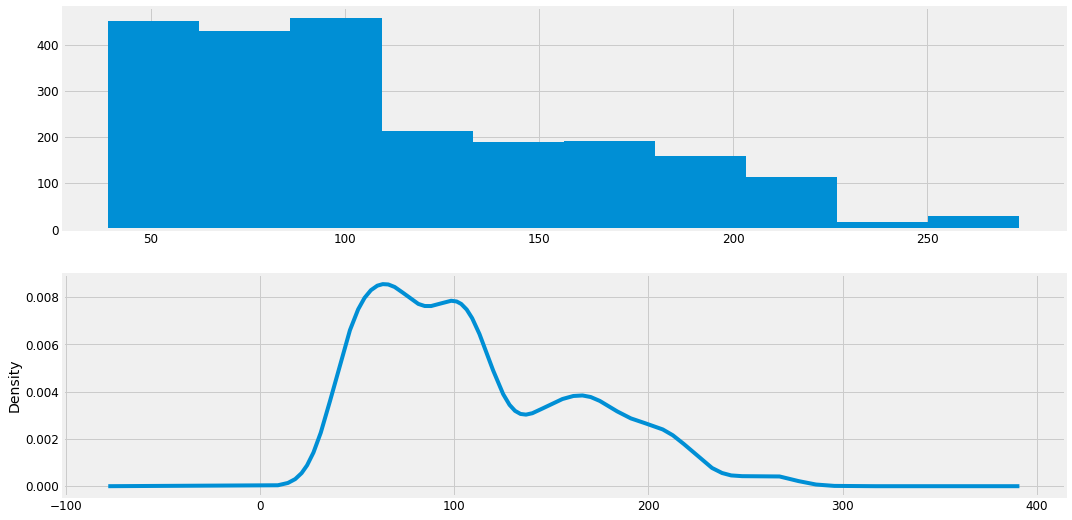

In [861]:
pyplot.figure(1)
pyplot.subplot(211)
y.Toneladas.hist()
pyplot.subplot(212)
y.Toneladas.plot(kind='kde')
pyplot.show()

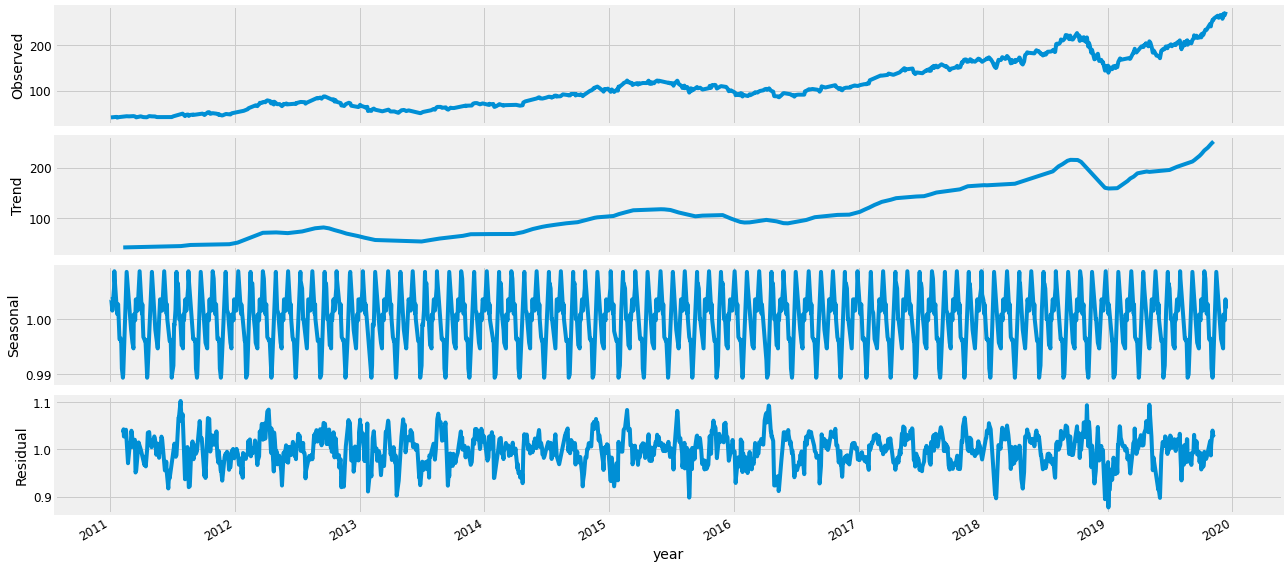

In [865]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',freq=50)
fig = decomposition.plot()
plt.show()

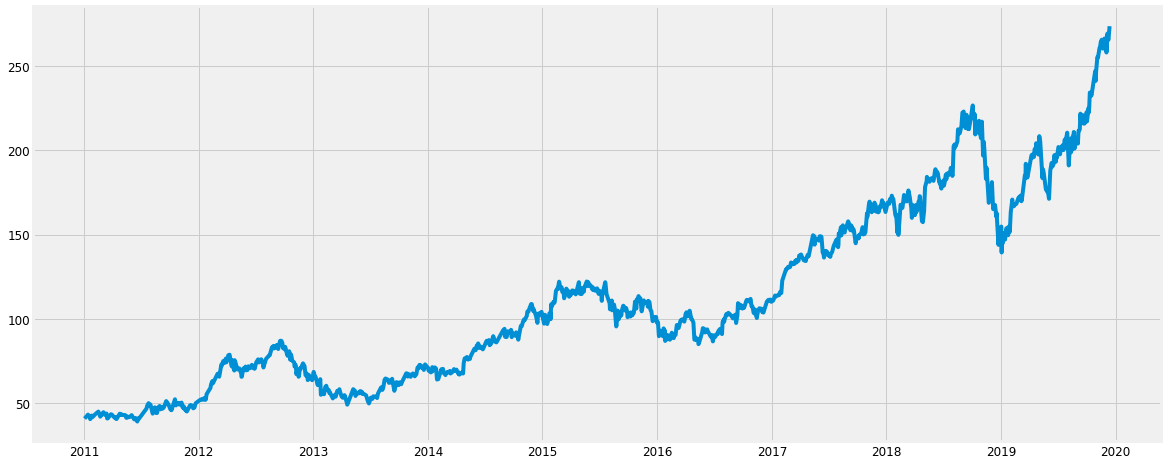

In [866]:
plt.plot(y)

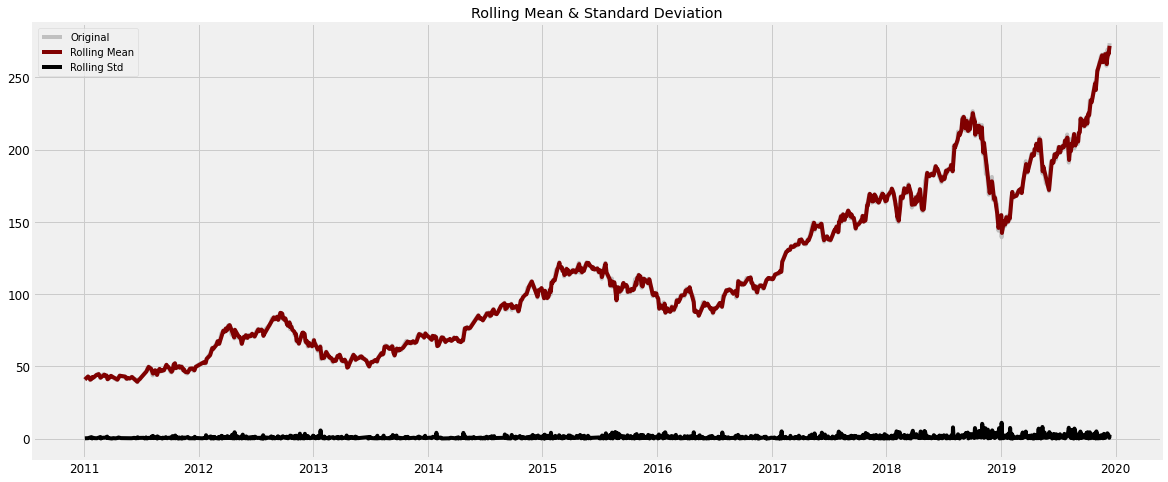

In [867]:
#Determing rolling statistics
rolmean = pd.Series.rolling(y, window=2).mean()
rolstd = pd.Series.rolling(y, window=2).std()

#Plot rolling statistics:
orig = plt.plot(y, color='silver',label='Original')
mean = plt.plot(rolmean, color='maroon', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [868]:
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.Toneladas, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    0.990048
p-value                           0.994160
#Lags Used                       17.000000
Number of Observations Used    2235.000000
Critical Value (1%)              -3.433279
Critical Value (5%)              -2.862834
Critical Value (10%)             -2.567459
dtype: float64


In [803]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=3).mean()
    rolstd = pd.Series.rolling(timeseries, window=3).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

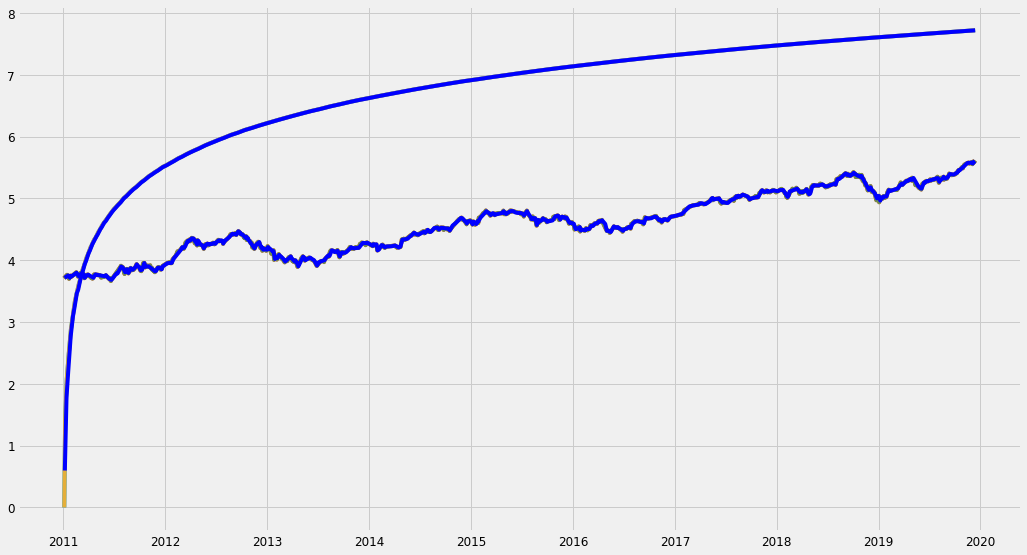

In [804]:
ts_log = np.log(y)
plt.plot(ts_log)
moving_avg = pd.Series.rolling(ts_log,3).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='blue')

In [805]:
print(ts_log)


               index  Toneladas
year                           
2011-01-03      -inf   3.707659
2011-01-04  0.000000   3.712864
2011-01-05  0.693147   3.721011
2011-01-06  1.098612   3.720202
2011-01-07  1.386294   3.727338
...              ...        ...
2019-12-09  7.717796   5.581875
2019-12-10  7.718241   5.587703
2019-12-11  7.718685   5.596196
2019-12-12  7.719130   5.598741
2019-12-13  7.719574   5.612243

[2253 rows x 2 columns]


In [806]:
print(ts_log.Toneladas)

year
2011-01-03    3.707659
2011-01-04    3.712864
2011-01-05    3.721011
2011-01-06    3.720202
2011-01-07    3.727338
                ...   
2019-12-09    5.581875
2019-12-10    5.587703
2019-12-11    5.596196
2019-12-12    5.598741
2019-12-13    5.612243
Name: Toneladas, Length: 2253, dtype: float64


In [807]:
print(moving_avg.Toneladas)


year
2011-01-03         NaN
2011-01-04         NaN
2011-01-05    3.713845
2011-01-06    3.718026
2011-01-07    3.722850
                ...   
2019-12-09    5.584897
2019-12-10    5.588517
2019-12-11    5.588591
2019-12-12    5.594213
2019-12-13    5.602393
Name: Toneladas, Length: 2253, dtype: float64


In [808]:
ts_log_moving_avg_diff = ts_log.Toneladas - moving_avg.Toneladas
ts_log_moving_avg_diff.head(12)

year
2011-01-03         NaN
2011-01-04         NaN
2011-01-05    0.007166
2011-01-06    0.002176
2011-01-07    0.004488
2011-01-10    0.014817
2011-01-11    0.004640
2011-01-12    0.004614
2011-01-13    0.005136
2011-01-14    0.006595
2011-01-18   -0.012461
2011-01-19   -0.011127
Name: Toneladas, dtype: float64

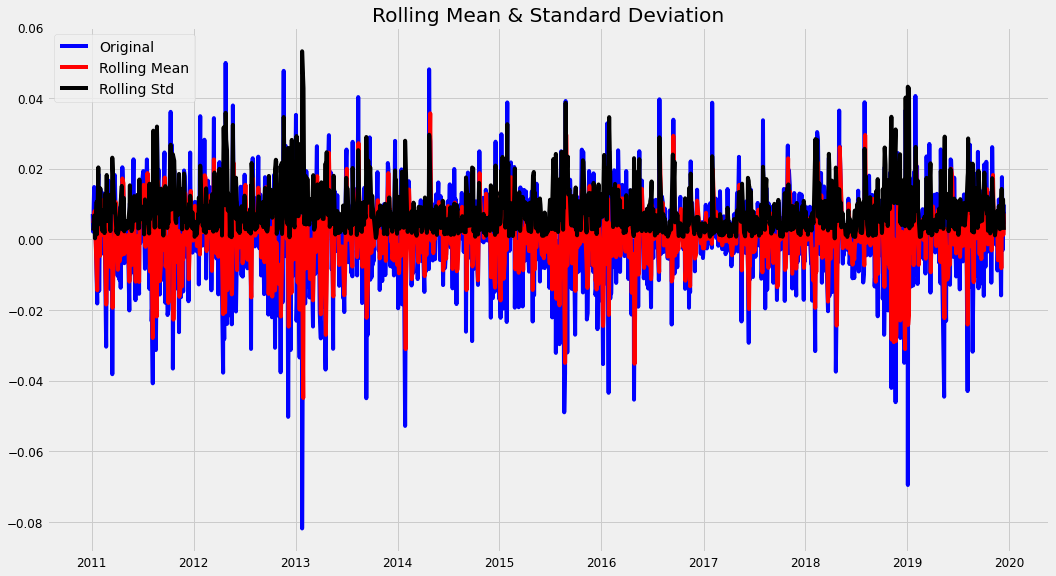

Results of Dickey-Fuller Test:
Test Statistic                -1.442874e+01
p-value                        7.693613e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.240000e+03
Critical Value (1%)           -3.433273e+00
Critical Value (5%)           -2.862831e+00
Critical Value (10%)          -2.567457e+00
dtype: float64


In [809]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)


Promedio ponderado exponencial

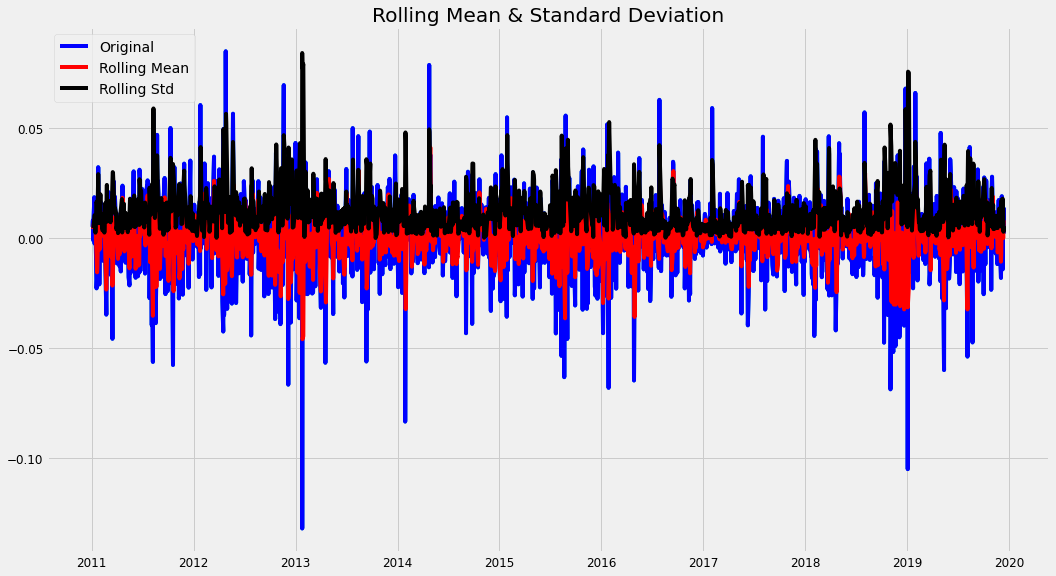

Results of Dickey-Fuller Test:
Test Statistic                -1.471458e+01
p-value                        2.813052e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.241000e+03
Critical Value (1%)           -3.433271e+00
Critical Value (5%)           -2.862831e+00
Critical Value (10%)          -2.567457e+00
dtype: float64


In [810]:
ts_log_diff = ts_log.Toneladas - ts_log.Toneladas.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Time Series forecasting


In [811]:
from statsmodels.tsa.ar_model import AR
from random import random

In [812]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

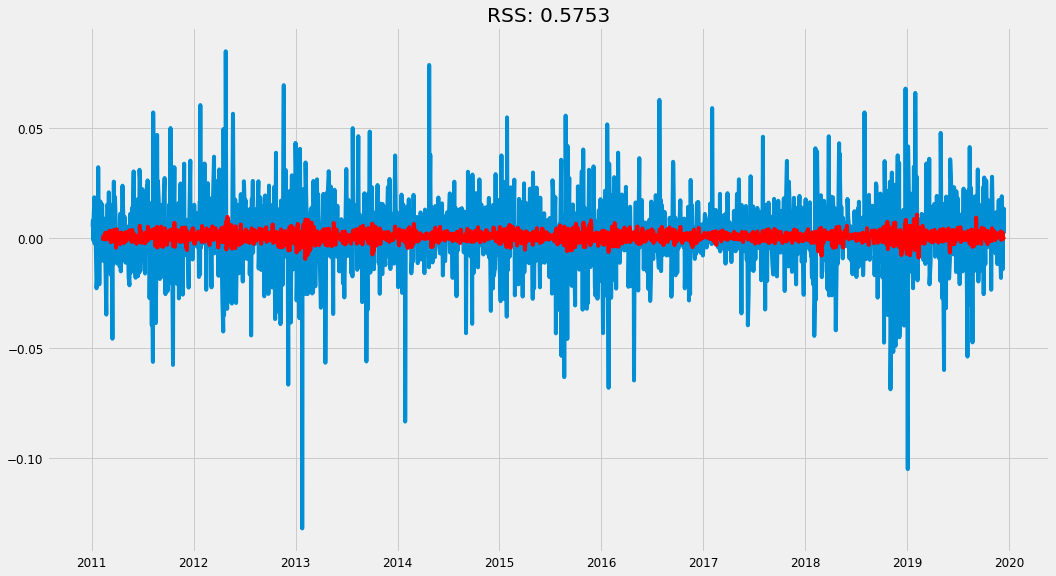

In [813]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

In [814]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
2011-02-10   -0.001039
2011-02-11    0.000914
2011-02-14    0.000409
2011-02-15    0.000789
2011-02-16   -0.000536
dtype: float64


In [815]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
2011-02-10   -0.001039
2011-02-11   -0.000125
2011-02-14    0.000284
2011-02-15    0.001073
2011-02-16    0.000537
dtype: float64


In [816]:
predictions_ARIMA_log = pd.Series(ts_log.Toneladas.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
2011-01-03    3.707659
2011-01-04    3.707659
2011-01-05    3.707659
2011-01-06    3.707659
2011-01-07    3.707659
dtype: float64

In [817]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)


Text(0.5, 1.0, 'RMSE: 15.8261')

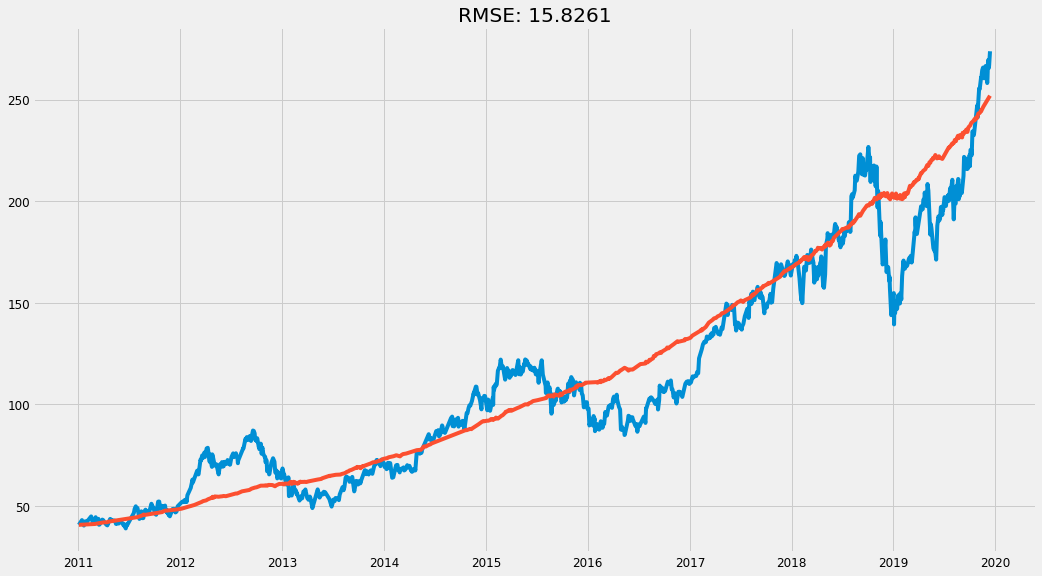

In [818]:
plt.plot(y.Toneladas)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.Toneladas)**2)/len(y.Toneladas)))

Autoregressive Moving Average (ARMA)

In [819]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

In [820]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Toneladas   No. Observations:                 2252
Model:                     ARMA(2, 1)   Log Likelihood                6090.417
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 02 Jul 2020   AIC                         -12170.834
Time:                        22:36:56   BIC                         -12142.237
Sample:                             0   HQIC                        -12160.397
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0008      0.000      2.535      0.011       0.000       0.001
ar.L1.Toneladas     0.3720      0.448      0.830      0.406      -0.506       1.250
ar.L2.Toneladas    -0.0311      0.021     -1.465      0.143      -0.073       0.010
ma.L1.Toneladas    -0.3559      0.448     -0.795      0.427      -1.234       0.522
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.0774           +0.0000j            4.0774            0.0000
AR.2            7.8928           +0.0000j            7.8928            0.0000
MA.1            2.8099           +0.0000j            2.8099            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.5903')

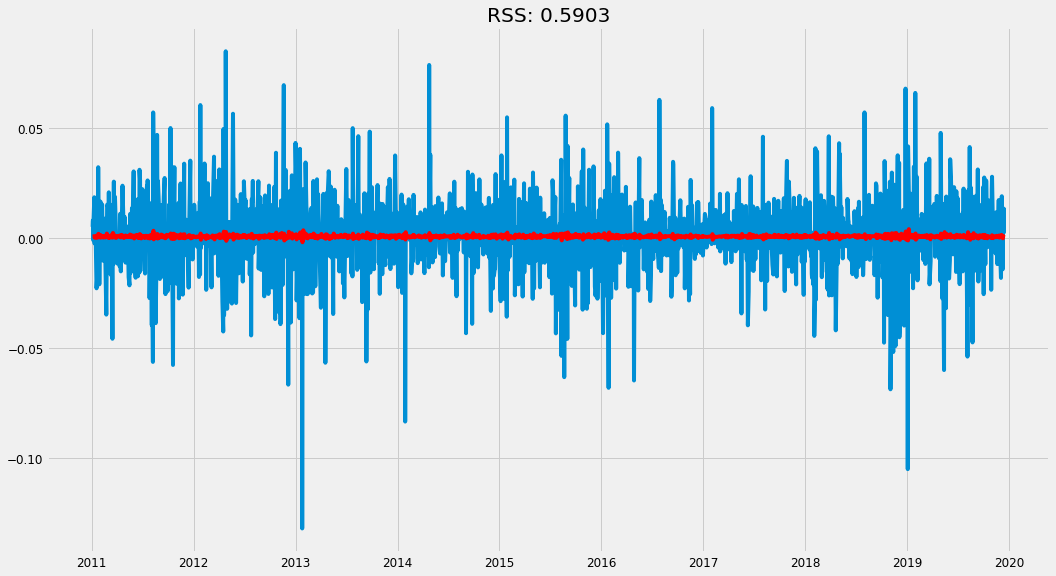

In [821]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

Autoregressive Integrated Moving Average (ARIMA)

In [822]:
ts = y.Toneladas - y.Toneladas.shift()
ts.dropna(inplace=True)

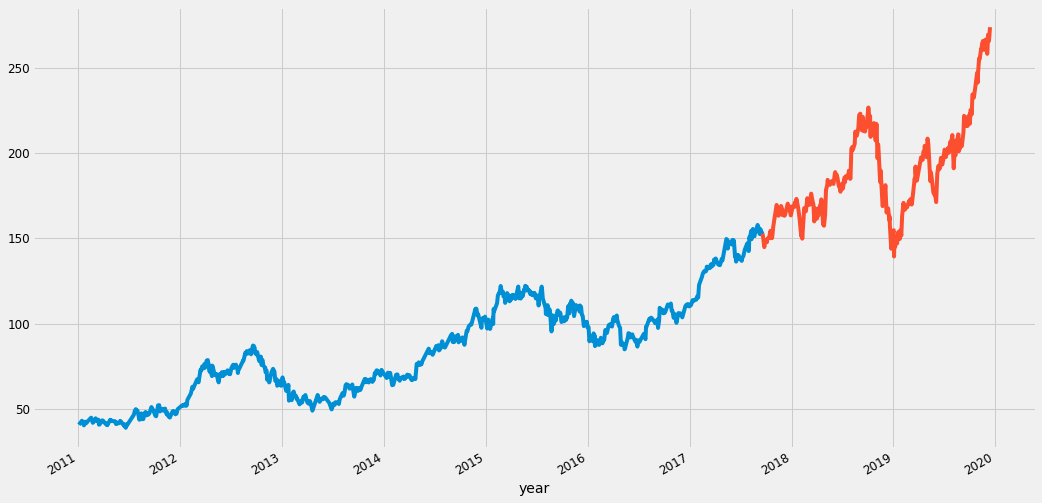

In [823]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['Toneladas'].plot()
valid['Toneladas'].plot()

In [824]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [ ]:
plt.plot(y.Toneladas)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()


# **CONCLUSIONES**

---
La data que se obtiene de las ventas por toneladas en los diferentes dias y meses tiene que ser limpiada mas a profundidad para que sea una data que nos ayude a predecir de mejor forma las futuras ventas.

Al realizar los dos modelos de Redes neuronales se comprobo que se adaptan a la perfeccion para el pronostico de las toneladas futuras de venta, pero por el tipo de data tan cambiante el rango de tiempo a predecir ser de una semana.

Entre los dos modelos de redes neuronales se obtuvo dos resultados parecidos, 

**Primer modelo: FeddForward**

Fase de entrenamiento                             Fase de Prueba
1.3 RMSE                                           4.8 RMSE

**Segundo Modelo**
Fase de entrenamiento                             Fase de Prueba
1.49 RMSE                                           3.10 RMSE



Los diferenes metodos de Forecasting no se los puede aplicar por cuanto no se tiene una estacionalidad definida en los datos.

